In [7]:
import os
import sys
import numpy as np
import scipy.io.wavfile as wav
import time
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [8]:
sample_rate, samples = wav.read('happy.wav')
n_samples = len(samples)
print('The original digital audio signal consists of',n_samples, 
      'samples, sampled at a rate of',sample_rate,'samples/sec.')

length = n_samples/sample_rate
print('Check that the recording lasts about',length,'seconds.')

t = np.linspace(0,length,n_samples)

The original digital audio signal consists of 14336 samples, sampled at a rate of 16000 samples/sec.
Check that the recording lasts about 0.896 seconds.


In [9]:
overlapFac = 0.5
window = np.hanning
frameSize = 2**10
dt = t[1]

if frameSize > len(samples):
    print('Be careful, your frame size is larger than your sample size')

############################################################
win = window(frameSize)
hopSize = int(frameSize - np.floor(overlapFac * frameSize))

# zeros at beginning (thus center of 1st window should be for sample nr. 0)
samples_left_pad = np.append(np.zeros(int(np.floor(frameSize/2.0)) ), samples)   

halfFSf = int(np.floor(frameSize/2.0))

t_left_pad = np.append(np.linspace(-halfFSf*dt,-t[1],halfFSf),t)

# number of cols for windowing
cols = int(np.ceil((len(samples_left_pad) - frameSize) / float(hopSize))) + 1

halfFS = int(np.ceil(frameSize/2.0)) 

# zeros at end (thus samples can be fully covered by frames)
samples_pad = np.append(samples_left_pad, np.zeros(halfFS))

t_pad = np.append(t_left_pad, np.linspace(t[-1],t[-1]+halfFS*dt,halfFS))



frames = np.lib.stride_tricks.as_strided(samples_pad, 
                                         shape=(cols, frameSize), 
                                         strides=(samples_pad.strides[0]*hopSize, 
                                         samples_pad.strides[0])).copy()

t_frames = np.lib.stride_tricks.as_strided(t_pad, 
                                         shape=(cols, frameSize), 
                                         strides=(t_pad.strides[0]*hopSize, 
                                         t_pad.strides[0])).copy()
win_frames = frames*win

# fast fourier transform
sfft = np.fft.rfft(win_frames)

In [10]:
n_timebins, n_freqbins = np.shape(sfft)

factor=1.0

scale = np.linspace(0, 1, n_freqbins) ** factor
scale *= (n_freqbins-1)/max(scale)   
scale = np.unique(np.round(scale).astype(int))


# create spectrogram with new freq bins
newspec = np.complex128(np.zeros([n_timebins, len(scale)]))
for i in range(0, len(scale)):
    if i == len(scale)-1:
        newspec[:,i] = np.sum(sfft[:,scale[i]:], axis=1)
    else:        
        newspec[:,i] = np.sum(sfft[:,scale[i]:scale[i+1]], axis=1)

# list center freq of bins
allfreqs = np.abs(np.fft.fftfreq(n_freqbins*2, 1./sample_rate)[:n_freqbins+1])
freqs = []
for i in range(0, len(scale)):
    if i == len(scale)-1:
        freqs += [np.mean(allfreqs[scale[i]:])]
    else:
        freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]

<IPython.core.display.Javascript object>


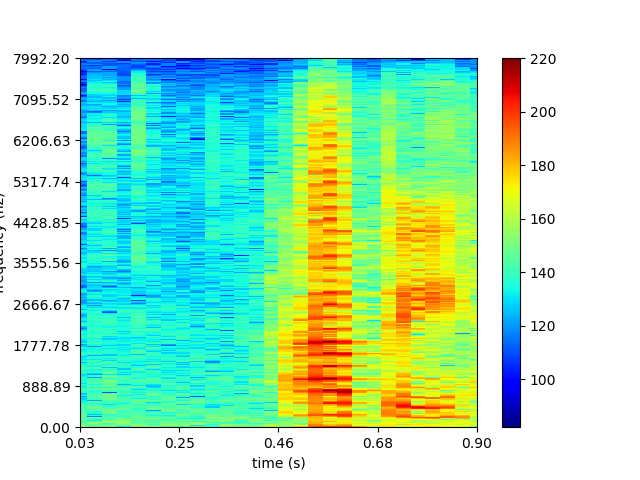

([<matplotlib.axis.YTick at 0x7feba28f97f0>,
 <a list of 10 Text yticklabel objects>)

In [11]:
colormap = 'jet'

ims = 20.*np.log10(np.abs(newspec)/10e-6) # amplitude to decibel

timebins, freqbins = np.shape(ims)

plt.subplots()
#plt.figure(figsize=(15, 7.5))
plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
plt.colorbar()

plt.xlabel("time (s)")
plt.ylabel("frequency (hz)")
plt.xlim([0, timebins-1])
plt.ylim([0, freqbins])

xlocs = np.float32(np.linspace(0, timebins-1, 5))
plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*frameSize))/sample_rate])
ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
plt.yticks(ylocs, ["%.02f" % freqs[i] for i in ylocs])